In [ ]:
import sys
from pathlib import Path

PROJECT_ROOT = Path("..").resolve()
sys.path.append(str(PROJECT_ROOT))

In [ ]:
import torch
import matplotlib.pyplot as plt
from ipywidgets import interact, FloatSlider, IntSlider
from PIL import Image

from src.architecture.model import FractalNet
from src.config import Config

In [ ]:
cfg_train = Config(PROJECT_ROOT / "configs/default.yaml")
cfg_fractal_all = Config(PROJECT_ROOT / "configs/fractal.yaml")
preset_name = cfg_train.get("generation", "preset")
cfg_fractal = cfg_fractal_all.get(preset_name)

device = "cuda" if torch.cuda.is_available() else "cpu"

model = FractalNet(
    hidden_dim=cfg_train.get("model", "hidden_dim"),
    num_layers=cfg_train.get("model", "num_layers"),
    num_frequencies=cfg_train.get("model", "num_frequencies")
).to(device)

model_path = PROJECT_ROOT / cfg_train.get("training", "model_path")
if model_path.exists():
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()
else:
    print("Model not found, using random initialization.")

In [ ]:
@torch.no_grad()
def render_fractal(model, resolution=512, x_range=(-2, 2), y_range=(-2, 2), scale=2.0, device="cpu"):
    x = torch.linspace(x_range[0], x_range[1], resolution)
    y = torch.linspace(y_range[0], y_range[1], resolution)
    grid_x, grid_y = torch.meshgrid(x, y, indexing="ij")
    
    coords = torch.stack([grid_x.flatten(), grid_y.flatten()], dim=1).to(device)
    coords = coords / scale

    rgb = model(coords).clamp(0, 1).cpu()
    img_array = (rgb.view(resolution, resolution, 3) * 255).byte().numpy()
    return Image.fromarray(img_array)

In [ ]:
def update_fractal(x_center=0.0, y_center=0.0, zoom=1.0, resolution=512):
    half_range = 2.0 / zoom
    x_range = (x_center - half_range, x_center + half_range)
    y_range = (y_center - half_range, y_center + half_range)

    img = render_fractal(model, resolution=resolution, x_range=x_range, y_range=y_range, scale=2.0)
    
    plt.figure(figsize=(7, 7))
    plt.imshow(img)
    plt.axis("off")
    plt.show()

interact(
    update_fractal,
    x_center=FloatSlider(min=-2.0, max=2.0, step=0.01, value=0.0, description="X Center"),
    y_center=FloatSlider(min=-2.0, max=2.0, step=0.01, value=0.0, description="Y Center"),
    zoom=FloatSlider(min=1.0, max=10.0, step=0.01, value=1.0, description="Zoom"),
    resolution=IntSlider(min=128, max=1024, step=64, value=512, description="Resolution")
)

# Static Output

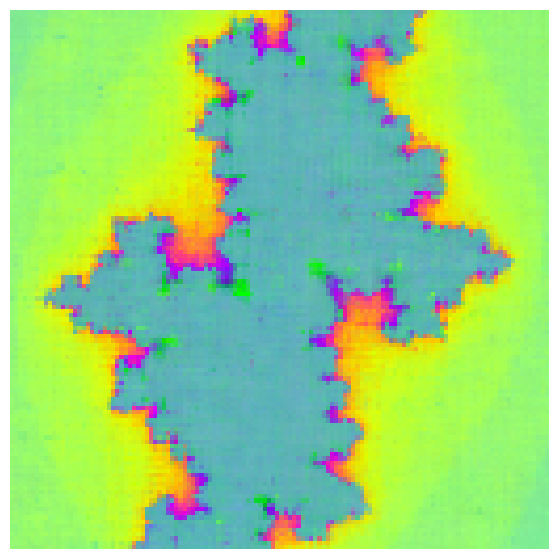

In [50]:
img = render_fractal(model, resolution=128)
plt.figure(figsize=(7, 7))
plt.imshow(img)
plt.axis("off")
plt.show()